In [1]:
%pylab inline
from sklearn.neural_network import MLPRegressor
import bilby
import redback
import pandas as pd
from bilby.core.prior import Constraint, PriorDict, Uniform
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [43]:
def line(x, m, c, **kwargs):
    return m*x+c

prior = bilby.core.prior.PriorDict()
prior['m'] = bilby.core.prior.Uniform(3, 8, 'm')
prior['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

In [44]:
xs = np.linspace(1, 20, 50)
models = 100
ys = np.zeros((models, len(xs)))
samples = pd.DataFrame(prior.sample(models))

In [45]:
for ii in range(models):
    ys[ii] = line(xs, **samples.iloc[ii].to_dict())
    plt.plot(xs, ys[ii], color='red', alpha=0.05)

In [46]:
X_train = samples.values
y_train = ys
regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train)

In [49]:
y_pred = regr.predict(np.array([4, -1]).reshape(1, -1))
print(y_pred.shape)

(1, 50)


In [48]:
y_true = line(xs, 4, -1)

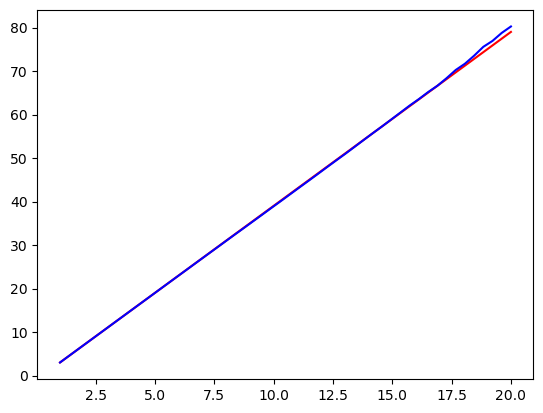

In [50]:
plt.plot(xs, y_true, color='red')
plt.plot(xs, y_pred[0,:], color='blue')

In [19]:
def afterglow(time, redshift,  thv, loge0 , thc, logn0, p, logepse, logepsb, ksin, g0, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', redshift=redshift,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=ksin, g0=g0, frequency= frequency)
    return ag_fluxd


In [20]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,300,300) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    minflux=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=1146839759677006.2)
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        fluxday1= np.interp(1,time,flux)
        minflux.append(fluxday1)
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    #filter on axis results (comment out if needed)
    #constrained_params['onaxis']= 0.05 - parameters['thv']
    #filter lower flux afterglows out for ON AXIS case (comment out if needed)
    #constrained_params['min_flux']= np.array(minflux) - 10e-7
    #filter off axis results (comment out if needed)
    constrained_params['offaxis']= parameters['thv'] - 0.06
    return constrained_params

In [21]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
#priors['onaxis']= Constraint(minimum=0, maximum=0.05)
#priors['min_flux']=Constraint(minimum=0, maximum=10)
priors['offaxis']= Constraint(minimum=0.06, maximum=(np.pi)/2)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000
priors['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)

num=5000
samples=priors.sample(num)
afterglow_data=pd.DataFrame.from_dict(samples)
afterglow_data

,redshift,thv,loge0,thc,logn0,p,logepse,logepsb,ksin,g0,frequency
0,0.01,1.536437,46.059400,0.030262,1.521544,2.3,-1.25,-2.5,1.0,1000.0,4.342841e+16
1,0.01,1.307014,49.812884,0.092725,0.647914,2.3,-1.25,-2.5,1.0,1000.0,1.652365e+17
2,0.01,0.152703,52.735619,0.011444,1.043223,2.3,-1.25,-2.5,1.0,1000.0,1.221629e+17
3,0.01,1.414248,50.468570,0.074931,-0.345310,2.3,-1.25,-2.5,1.0,1000.0,1.736654e+17
4,0.01,1.099110,49.535735,0.028083,-2.297651,2.3,-1.25,-2.5,1.0,1000.0,8.562600e+15
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.01,1.438559,48.411882,0.095127,-0.493636,2.3,-1.25,-2.5,1.0,1000.0,1.307928e+16
4996,0.01,0.823087,49.199841,0.071762,0.496586,2.3,-1.25,-2.5,1.0,1000.0,6.367490e+15
4997,0.01,1.377026,49.974040,0.018552,1.305903,2.3,-1.25,-2.5,1.0,1000.0,1.578960e+16
4998,0.01,0.493388,51.986968,0.053754,0.625679,2.3,-1.25,-2.5,1.0,1000.0,1.044365e+17


In [22]:
time = np.linspace(0.1, 300, 300) #xs
ys = np.zeros((num, len(time)))  #ys

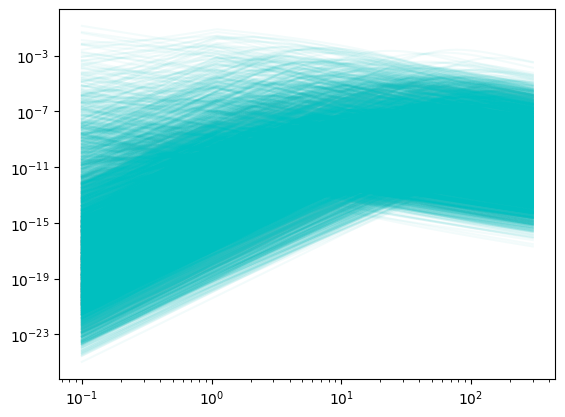

In [24]:
ax= plt.subplot()

for i in range(num):
    ys[i]= afterglow(time, **afterglow_data.iloc[i])
    ax.loglog(time, ys[i], color='c', alpha=0.05)
plt.show()

In [25]:
X = afterglow_data.values
Y = ys
regr = MLPRegressor(random_state=7, max_iter=7000).fit(X, Y)

In [26]:
params=np.array([0.01, 0.5, 50.0 , 0.02, 1, 2.13,-1.25, -2.5, 1, 1000, 4e14])
prediction = regr.predict(params.reshape(1,-1))
prediction.shape

(1, 300)

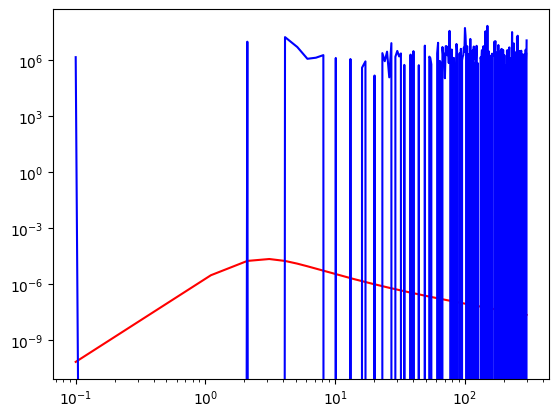

In [28]:
test_params= dict(redshift=0.01,  thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
     frequency= 4e14)
true_value= afterglow(time, **test_params)
ax1=plt.subplot()
ax1.loglog(time, true_value, color='red')
ax1.loglog(time, prediction[0,:], color='blue') #ls='None', marker='x')
plt.show()